#### TMCMC sampling for the multidimensional mass-spring-damper system

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt

import My_TMCMC

np.random.seed(106)  # fixing the random seed

## SIRD Model

The SIRD model used in this example has the following form:

\begin{align}
\frac{dS}{dt} & = -\beta S I \\
\frac{dI}{dt} & = \beta S I - \gamma I - \delta I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dD}{dt} & = \delta I
\end{align}

with parameters $\beta$, $\gamma$, and $\delta$ representing the infection rate, the recovery rate and the death rate, respectively.

In [2]:
Npar = 3 # number of unknown parameters
phiTrue = [0.191,0.05,0.0294]
phiNN = [ 0.200491,0.0517334,0.03113]
X_low = [0,0,0]
X_up = [1,1,1]
mylabel = [r'$\beta$',r'$\gamma$',r'$\delta$']

50


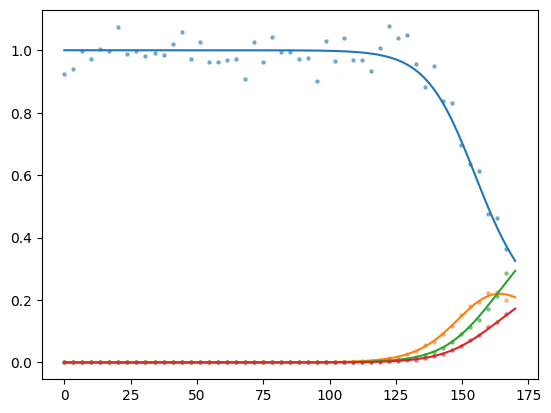

In [3]:
T = 170 # total time for forward integration
sampFac = 34 # sample every sampFac time step
dt = 1/10 # timestep
tgrd = 10*T # time integration grid
tlist = np.linspace(0,T,tgrd)
dof = 4
obsInd = [0,1,2,3]

noiseSigma = 0.05

I0 = 1/59e6 

beta = 0.191
gamma = 0.05
mu = 0.0294

YTrue = np.zeros((4,tgrd))
YTrue[:,0] = np.array([1-I0,I0,0,0])
for kk in range(1,tgrd):
  YTrue[0,kk] = YTrue[0,kk-1] + dt*(-beta*YTrue[0,kk-1]*YTrue[1,kk-1])
  YTrue[1,kk] = YTrue[1,kk-1] + dt*(beta*YTrue[0,kk-1] - gamma - mu)*YTrue[1,kk-1]
  YTrue[2,kk] = YTrue[2,kk-1] + dt*(gamma*YTrue[1,kk-1])
  YTrue[3,kk] = YTrue[3,kk-1] + dt*(mu*YTrue[1,kk-1])


np.random.seed(116)
tobs = tlist[0::sampFac]
Yobs = np.zeros((len(obsInd),len(tobs)))
Nobs = len(tobs)

for i in range(len(obsInd)):
    Yobs[i,:] = YTrue[obsInd[i],::sampFac]*(1 + noiseSigma*np.random.normal(0,1,Nobs))


for ii in range(len(obsInd)):
    plt.plot(tlist,YTrue[ii,:])
    plt.scatter(tobs,Yobs[ii,:],s=5,alpha=0.5)

print(Nobs)

In [4]:
def sird_model(parVecIn):
    beta = parVecIn[0]
    gamma = parVecIn[1]
    delta = parVecIn[2]

    T = 170 # total time for forward integration
    sampFac = 34 # sample every sampFac time step
    dt = 1/10 # timestep
    tgrd = 10*T # time integration grid
    tlist = np.linspace(0,T,tgrd)

    Yeval = np.zeros((dof,tgrd))
    Yeval[:,0] = np.array([1-I0,I0,0,0])
    for kk in range(1,tgrd):
      Yeval[0,kk] = Yeval[0,kk-1] + dt*(-beta*Yeval[0,kk-1]*Yeval[1,kk-1])
      Yeval[1,kk] = Yeval[1,kk-1] + dt*(beta*Yeval[0,kk-1] - gamma - delta)*Yeval[1,kk-1]
      Yeval[2,kk] = Yeval[2,kk-1] + dt*(gamma*Yeval[1,kk-1])
      Yeval[3,kk] = Yeval[3,kk-1] + dt*(delta*Yeval[1,kk-1])

    return Yeval[:,0::sampFac]

T_true = 500
tgrd_true = 10*T_true
tlist_true = np.linspace(0,T_true,tgrd_true)

def sird_forecast(parVecIn):

    beta = parVecIn[0]
    gamma = parVecIn[1]
    delta = parVecIn[2]

    Yeval = np.zeros((dof,tgrd_true))
    Yeval[:,0] = np.array([1-I0,I0,0,0])
    for kk in range(1,tgrd_true):
      Yeval[0,kk] = Yeval[0,kk-1] + dt*(-beta*Yeval[0,kk-1]*Yeval[1,kk-1])
      Yeval[1,kk] = Yeval[1,kk-1] + dt*(beta*Yeval[0,kk-1] - gamma - delta)*Yeval[1,kk-1]
      Yeval[2,kk] = Yeval[2,kk-1] + dt*(gamma*Yeval[1,kk-1])
      Yeval[3,kk] = Yeval[3,kk-1] + dt*(delta*Yeval[1,kk-1])

    return Yeval

def loglikfun(parVecIn):
    noiseSig = 0.05
    loglikfun_s,loglikfun_i,loglikfun_d,loglikfun_r  = 0.0, 0.0, 0.0, 0.0

    Yresp = sird_model(parVecIn)
    
    for i in range(0,Nobs):
        loglikfun_s = loglikfun_s + ((Yobs[0,i])/(Yresp[0,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[0,i])+1e-12)
        loglikfun_i = loglikfun_i + ((Yobs[1,i])/(Yresp[1,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[1,i])+1e-12)
        loglikfun_d = loglikfun_d + ((Yobs[2,i])/(Yresp[2,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[2,i])+1e-12)
        loglikfun_r = loglikfun_r + ((Yobs[3,i])/(Yresp[3,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[3,i])+1e-12)
    return -loglikfun_s  -loglikfun_i  -loglikfun_r -loglikfun_d

def logpriorpdf(parVecIn): ## Only define priors for \phi_{-\alpha}
        logprior = 0.0
        # rv12 = st.lognorm(0.57536,0,0.15) # beta is a uniform distibution between 0 and 0.5
        # logprior = logprior + rv12.logpdf(parVecIn[2])
        # rv13 = st.lognorm(0.5,0,0.075) # gamma is a uniform distibution between 1/21 and 1/1
        # logprior = logprior + rv13.logpdf(parVecIn[3])
        return logprior

def logpostprob(phiIn):
    #return logpriorpdf(phiIn) + loglikfun(phiIn)
    return loglikfun(phiIn)

In [5]:
# def loglikfun(parVecIn):

#     beta = parVecIn[0]
#     gamma = parVecIn[1]
#     delta = parVecIn[2]

#     noiseSig = 0.05
#     loglikfun_s,loglikfun_i,loglikfun_d,loglikfun_r  = 0.0, 0.0, 0.0, 0.0

#     T = 500 # total time for forward integration
#     sampFac = 50 # sample every sampFac time step
#     dt = 1/10 # timestep
#     tgrd = 10*T # time integration grid
#     tlist = np.linspace(0,T,tgrd)

#     Yeval = np.zeros((dof,tgrd))
#     Yeval[:,0] = np.array([1-I0,I0,0,0])
#     for kk in range(1,tgrd):
#       Yeval[0,kk] = Yeval[0,kk-1] + dt*(-beta*Yeval[0,kk-1]*Yeval[1,kk-1])
#       Yeval[1,kk] = Yeval[1,kk-1] + dt*(beta*Yeval[0,kk-1] - gamma - delta)*Yeval[1,kk-1]
#       Yeval[2,kk] = Yeval[2,kk-1] + dt*(gamma*Yeval[1,kk-1])
#       Yeval[3,kk] = Yeval[3,kk-1] + dt*(delta*Yeval[1,kk-1])

#       Yresp = Yeval[:,0::sampFac]

#     for i in range(0,Nobs):
#         loglikfun_s = loglikfun_s + ((Yobs[0,i])/(Yresp[0,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[0,i])+1e-12)
#         loglikfun_i = loglikfun_i + ((Yobs[1,i])/(Yresp[1,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[1,i])+1e-12)
#         loglikfun_d = loglikfun_d + ((Yobs[2,i])/(Yresp[2,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[2,i])+1e-12)
#         loglikfun_r = loglikfun_r + ((Yobs[3,i])/(Yresp[3,i]+1e-12) - 1)**2/(2.0*noiseSig**2)  + np.log(noiseSig) + 0.5*np.log(2*np.pi) + np.log(np.abs(Yresp[3,i])+1e-12)
#     return -loglikfun_s  -loglikfun_i  -loglikfun_r -loglikfun_d


# def logpriorpdf(parVecIn): ## Only define priors for \phi_{-\alpha}
#         logprior = 0.0
#         # rv12 = st.lognorm(0.57536,0,0.15) # beta is a uniform distibution between 0 and 0.5
#         # logprior = logprior + rv12.logpdf(parVecIn[2])
#         # rv13 = st.lognorm(0.5,0,0.075) # gamma is a uniform distibution between 1/21 and 1/1
#         # logprior = logprior + rv13.logpdf(parVecIn[3])
#         return logprior
# def logpostprob(phiIn):
#     #return logpriorpdf(phiIn) + loglikfun(phiIn)
#     return loglikfun(phiIn)


In [7]:
run_mcmc = 0

if run_mcmc == 1:    
    import time
    start = time.time()

    Nsmp = 2000
    MHfac = 0.2
    Xsmp,Chain,LLsmp, Evid, tmcmcFac  = My_TMCMC.TMCMC(logpostprob,Npar,X_low,X_up,Nsmp)

    end = time.time()
    print(end - start)
else:
    Nsmp = 2000
    Xsmp = np.loadtxt('sird_1_samples.dat')
    Chain = np.loadtxt('sird_1_chain.dat')

(3, 30000)
(3, 2000)


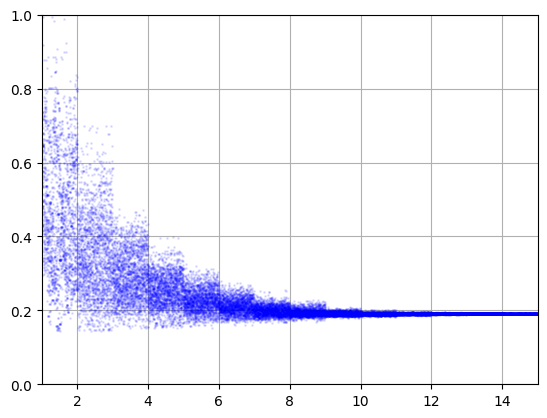

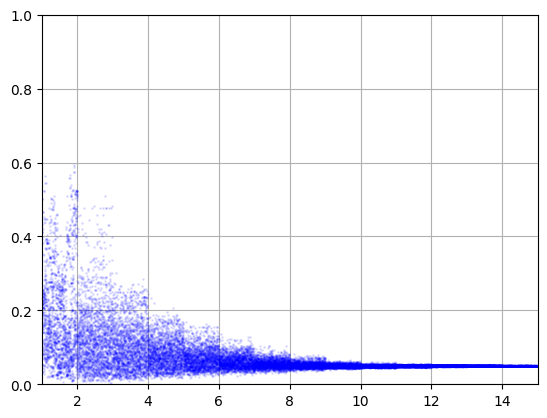

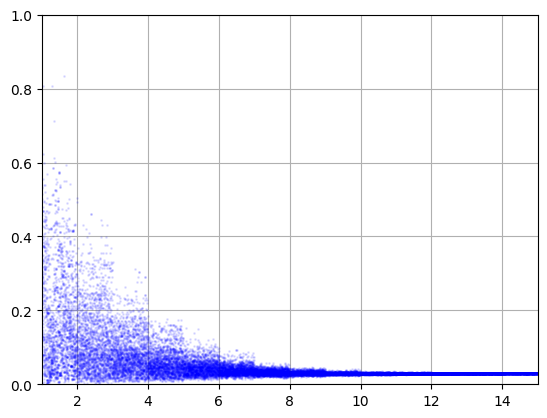

In [8]:
print(np.shape(Chain))
print(np.shape(Xsmp))

for ii in range(Npar):
  plt.figure(ii)
  plt.plot((1/Nsmp)*np.arange(0,len(Chain[ii,:])),Chain[ii,:],'b.',markersize=2,alpha=0.1)
  plt.ylim([X_low[ii],X_up[ii]])
  plt.xlim([1,15])
  # plt.xlabel(mylabel[ii])
  plt.grid(True)


In [8]:
np.savetxt('sird_1_samples.dat',Xsmp)
np.savetxt('sird_1_chain.dat',Chain)

statSmp = Xsmp.copy()
kdeMCMC= st.gaussian_kde(statSmp,bw_method = 0.1)
SigMat = kdeMCMC.covariance
# np.savetxt('SigMat.dat',SigMat)

import scipy.stats as st
from scipy.optimize import minimize
kde = st.gaussian_kde(statSmp )
def kde_fun(x):
  return -kde(x)
res = minimize(kde_fun,phiTrue, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})

maps = res.x
mean = np.mean(statSmp,axis=1)
#np.savetxt('Case01Model2-map.dat')
print(maps,mean)

Optimization terminated successfully.
         Current function value: -12621665635.330488
         Iterations: 109
         Function evaluations: 204
[0.19105914 0.05011196 0.02934855] [0.19115286 0.05017563 0.02938693]


0.2316230351238589


/tmp/ipykernel_33128/1771437525.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])


0.2316230351238589
0.2316230351238589


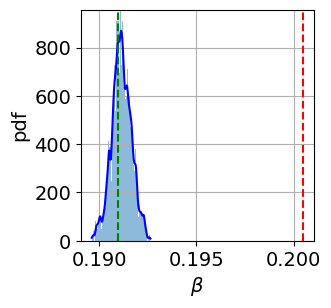

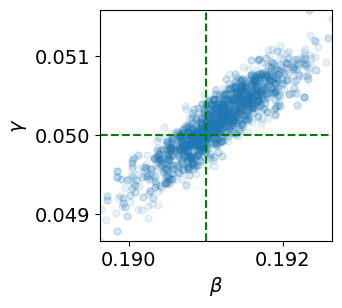

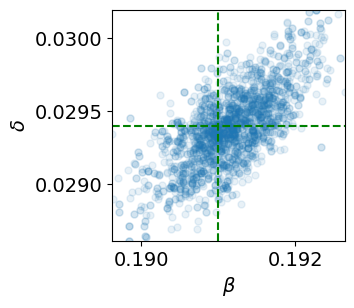

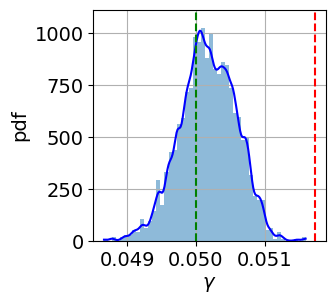

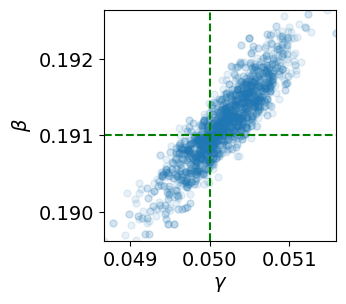

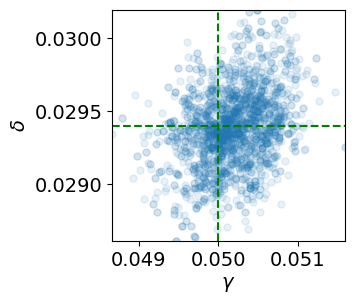

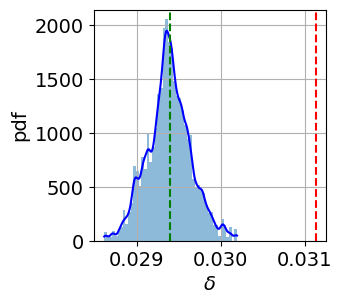

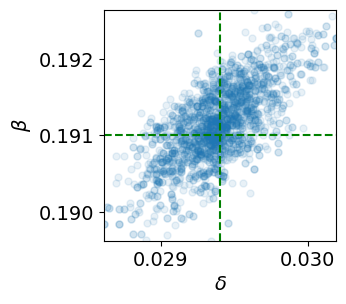

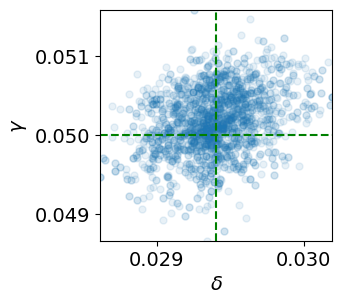

In [9]:
mpl.rcParams.update({'font.size':14})
statSmp = Xsmp
bandwidth = [0.1,0.1,0.1]


for j in range(0,Npar):
    xlow,xup = np.min(statSmp[j,:]),np.max(statSmp[j,:])
    f, ax = plt.subplots(1, figsize=(3,3))
    #Xpdf = st.kde.gaussian_kde(statSmp[j,:])
    Xpdf = st.kde.gaussian_kde(statSmp[j,:],bw_method = bandwidth[j])
    print(Xpdf.silverman_factor())
    Xgrd = np.linspace(xlow,xup,201)
    # Xgrd = np.linspace(X_low[j],X_up[j],100)
    plt.plot(Xgrd,Xpdf(Xgrd),'b-')
    plt.hist(statSmp[j,:], bins=50, density=True,alpha=0.5)
    pdfmax = max(Xpdf(Xgrd))
    myYlim = [0.0, 1.1*pdfmax]
    plt.plot([phiTrue[j],phiTrue[j]],myYlim,'--g',label='True')
    plt.plot([phiNN[j],phiNN[j]],myYlim,'--r',label='True')
    # plt.legend(loc='upper left', numpoints = 1)
    plt.ylabel('pdf')
    plt.xlabel(mylabel[j])
    #plt.xlim([np.min(statSmp[j,:]),np.max(statSmp[j,:])])
    plt.ylim(myYlim)
    # plt.xlim([min(phiNN[j]/1.01,xlow),max(xup,phiNN[j]*1.01)])
    # plt.xlim([X_low[j],X_up[j]])
    # plt.yticks([])
    plt.grid(True)
    # plt.savefig('mpdf_'+str(j)+'.pdf',bbox_inches='tight')

    for jj in range(Npar):
        if j != jj:            
            ylow,yup = np.min(statSmp[jj,:]),np.max(statSmp[jj,:])
            f, ax = plt.subplots(1, figsize=(3,3))
            plt.scatter(statSmp[j,::1],statSmp[jj,::1],alpha=0.1,s=25)
            plt.plot([xlow,xup],[phiTrue[jj],phiTrue[jj]],'--g',label='True')
            plt.plot([phiTrue[j],phiTrue[j]],[ylow,yup],'--g',label='True')
            plt.plot([xlow,xup],[phiNN[jj],phiNN[jj]],'--r',label='True')
            plt.plot([phiNN[j],phiNN[j]],[ylow,yup],'--r',label='True')
            plt.xlim([xlow,xup])
            plt.ylim([ylow,yup])
            # plt.xlim([X_low[j],X_up[j]])
            # plt.ylim([X_low[jj],X_up[jj]])
            plt.xlabel(mylabel[j])
            plt.ylabel(mylabel[jj])
            # plt.ylim([0,5e5])
            # plt.xlim([0,8e5])
            # plt.savefig('figures/m1_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
            # plt.close()

In [10]:
mpl.rcParams.update({'font.size':12})
Ytrue = sird_forecast(phiTrue)
YNN = sird_forecast(phiNN)
Nreal = 50
Yreal = np.zeros((dof,Nreal,tgrd_true))
Ystd = np.zeros((dof,tgrd_true))
Ymean = np.zeros((dof,tgrd_true))

# c_map = [4,400]

muVec = Xsmp
# Ymap = Yresponse(c_map)
for j in range(0,Nreal):
  Ysim = sird_forecast(muVec[:,j*1])
  for i in range(dof):
    #Ysim = Yresponse([0,0,muVec[j]])
    Yreal[i,j,:] = Ysim[i,:]

# for i in range(dof):
#   Ystd[i,:] = np.std(Yreal[i,:,:],0)
#   Ymean[i,:] = np.mean(Yreal[i,:,:],0)


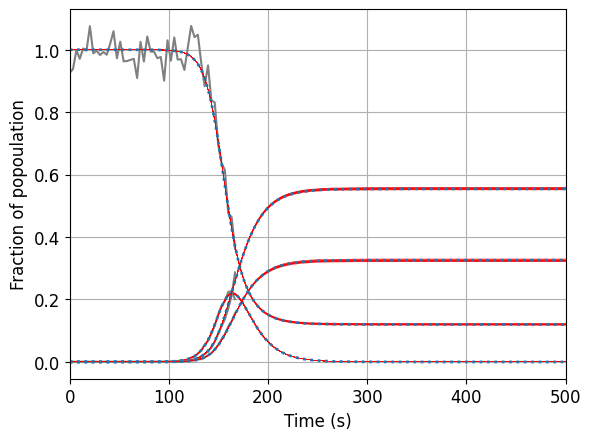

In [19]:
for i in range(dof):
  lwidth = 0.1
  #plt.figure(1,figsize=(8,3))
  #fig, ax = plt.subplots()
  #plt.plot(tobs,Yobs,'k.',label='Observations')
  plt.grid(True)
  plt.xlabel('Time (s)')
  plt.ylabel('Fraction of popoulation')
  # plt.scatter(tobs,Yobs[i,:],color='w',edgecolor='k')
  plt.plot(tobs,Yobs[i,:],color='grey', label = 'Observations')
  # plt.plot(tlist_true,Ymean[i,:],color='r',linestyle='--',linewidth=2,label='Predicted')
  plt.plot(tlist_true,Yreal[i,:].T,linewidth=0.1,alpha=1,color='r', label = 'BI predictions')
  # plt.plot(tlist,Ymean[i,:]+2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2,label='99/% region')
  # plt.plot(tlist,Ymean[i,:]-2*Ystd[i,:],color='tab:red',linestyle='--',linewidth=1.2)
  
  #   plt.legend(loc='upper right', numpoints = 1)
  # ax.fill_between(tlist, Y2, Y1, where=Y2 >= Y1, facecolor='pink', interpolate=True)
  plt.plot(tlist_true,Ytrue[i,:],'tab:blue',linestyle=':',linewidth=2,label = 'True')
  plt.xlim([0,T_true])
  # plt.ylim([-50,50])
  # plt.savefig('figs/predictions_before_dof_'+str(i)+'.pdf',bbox_inches='tight')

plt.show()